In [3]:
# Libraries
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score
)
import numpy as np

# Install latest XGBoost + CatBoost
!pip install -U xgboost catboost

In [4]:
# UPLOAD ZIP & LOAD DATA
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/")

csv_file = [f for f in os.listdir("/content/") if f.endswith(".csv")][0]
df = pd.read_csv("/content/" + csv_file)

print("Dataset Loaded Successfully!")
print(df.head(), "\n")
print(df.info(), "\n")


# CLEANING
df = df.fillna(method='ffill')
print(df.isnull().sum())


Saving archive (3).zip to archive (3) (2).zip
Dataset Loaded Successfully!
                             Patient_ID  Age     Sex Family_History  \
0  b2a49170-8561-4665-9371-2240b55dd87a   31    Male             No   
1  f5fae45d-8718-41c4-a957-6928f79f3c8e   33  Female            Yes   
2  66ab0567-050b-4d56-9ec4-b676309899a6   69    Male            Yes   
3  996a48e4-e841-418f-a539-5a7a86cd815d   66    Male            Yes   
4  d45c7ca8-7125-4aaa-8018-5bbc60d35a1f   43  Female            Yes   

   HTT_CAG_Repeat_Length Motor_Symptoms Cognitive_Decline  Chorea_Score  \
0                     67       Moderate            Severe          8.80   
1                     38         Severe          Moderate          3.24   
2                     37         Severe          Moderate          1.01   
3                     50           Mild            Severe          3.21   
4                     48       Moderate              Mild          2.31   

   Brain_Volume_Loss  Functional_Capacity  ... 

/tmp/ipython-input-3434141191.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Patient_ID                   0
Age                          0
Sex                          0
Family_History               0
HTT_CAG_Repeat_Length        0
Motor_Symptoms               0
Cognitive_Decline            0
Chorea_Score                 0
Brain_Volume_Loss            0
Functional_Capacity          0
Gene_Mutation_Type           0
HTT_Gene_Expression_Level    0
Protein_Aggregation_Level    0
Random_Protein_Sequence      0
Random_Gene_Sequence         0
Disease_Stage                0
Gene/Factor                  0
Chromosome_Location          0
Function                     0
Effect                       0
Category                     0
dtype: int64


In [5]:

#  REMOVE HIGH-LEAKAGE COLUMNS
df = df.drop(columns=[
    "Patient_ID", "Function", "Effect", "Gene/Factor",
    "Chromosome_Location", "Random_Protein_Sequence",
    "Random_Gene_Sequence"
], errors='ignore')


#LABEL ENCODING
label_encoders = {}
for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print(df["Motor_Symptoms"].value_counts())
print(df["Disease_Stage"].value_counts())
print(df["Category"].value_counts())

Motor_Symptoms
1    16261
2    16157
0    16118
Name: count, dtype: int64
Disease_Stage
2    12289
3    12191
0    12032
1    12024
Name: count, dtype: int64
Category
2    24279
1    12229
0    12028
Name: count, dtype: int64


In [6]:
#SPLIT DATA
X = df.drop(columns=["Motor_Symptoms", "Disease_Stage", "Category"])
y_targets = ["Motor_Symptoms", "Disease_Stage", "Category"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(
    X_scaled, test_size=0.2, random_state=42
)


In [7]:
# IMPORT MODELS
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

results = []      # for accuracy tables
train_outputs = [] # to print full train predictions
test_outputs = []  # to print full test predictions


# MODEL TRAINING FUNCTION
def run_model(target, model_name):
    print("\n========================================")
    print(f"Training {model_name} for: {target}")
    print("========================================")

    y = df[target]
    y_train, y_test = train_test_split(
        y, test_size=0.2, random_state=42
    )

    # Select model
    if model_name == "XGBoost":
        model = XGBClassifier(
            eval_metric='mlogloss',
            random_state=42,
            use_label_encoder=False
        )
    else:
        model = CatBoostClassifier(
            random_state=42,
            silent=True
        )

    # Train
    model.fit(X_train, y_train)

    # Predict on both sets
    train_pred = model.predict(X_train).ravel() # Added .ravel() to ensure 1D array
    test_pred  = model.predict(X_test).ravel()  # Added .ravel() to ensure 1D array

    # Calculate accuracy
    acc_train = accuracy_score(y_train, train_pred)
    acc_test  = accuracy_score(y_test, test_pred)

    print(f"Train Accuracy: {acc_train:.4f}  (Expected Overfitting)")
    print(f"Test Accuracy:  {acc_test:.4f}\n")

    # Store for summary
    results.append([model_name, target, acc_train, acc_test])

    # ===== Store full prediction tables =====
    train_df = pd.DataFrame({
        f"{target}_True": y_train,
        f"{target}_Pred": train_pred,
    })
    train_df[f"{target}_Correct"] = train_df[f"{target}_True"] == train_df[f"{target}_Pred"]

    test_df = pd.DataFrame({
        f"{target}_True": y_test,
        f"{target}_Pred": test_pred,
    })
    test_df[f"{target}_Correct"] = test_df[f"{target}_True"] == test_df[f"{target}_Pred"]

    return train_df, test_df






In [8]:
# RUN BOTH MODELS ON ALL TARGETS
for model_type in ["XGBoost", "CatBoost"]:
    for target in y_targets:
        tr, ts = run_model(target, model_type)
        train_outputs.append(tr)
        test_outputs.append(ts)



#  MERGE FULL TRAIN/TEST PREDICTIONS
full_train_df = pd.concat(train_outputs, axis=1)
full_test_df = pd.concat(test_outputs, axis=1)

print("\n\n==================== FULL TRAIN DATASET WITH PREDICTIONS ====================")
print(full_train_df.head(50))

print("\n\n==================== FULL TEST DATASET WITH PREDICTIONS ====================")
print(full_test_df.head(50))



# ===================== PERFORMANCE TABLE =====================
results_df = pd.DataFrame(results, columns=[
    "Model", "Target", "Train Accuracy", "Test Accuracy"
])

print("\n========= FINAL ACCURACY TABLE (OVERFITTING CHECK) ========")
print(results_df)


Training XGBoost for: Motor_Symptoms


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.7383  (Expected Overfitting)
Test Accuracy:  0.3318


Training XGBoost for: Disease_Stage


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.6949  (Expected Overfitting)
Test Accuracy:  0.2510


Training XGBoost for: Category


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.6404  (Expected Overfitting)
Test Accuracy:  0.4747


Training CatBoost for: Motor_Symptoms
Train Accuracy: 0.6494  (Expected Overfitting)
Test Accuracy:  0.3270


Training CatBoost for: Disease_Stage
Train Accuracy: 0.6060  (Expected Overfitting)
Test Accuracy:  0.2438


Training CatBoost for: Category
Train Accuracy: 0.5756  (Expected Overfitting)
Test Accuracy:  0.4805



==================== FULL TRAIN DATASET WITH PREDICTIONS ====================
       Motor_Symptoms_True  Motor_Symptoms_Pred  Motor_Symptoms_Correct  \
23668                    1                    1                    True   
13802                    1                    2                   False   
6551                     0                    0                    True   
21202                    2                    2                    True   
38343                    2                    2                    True   
36383                    0                    1                   False   
1

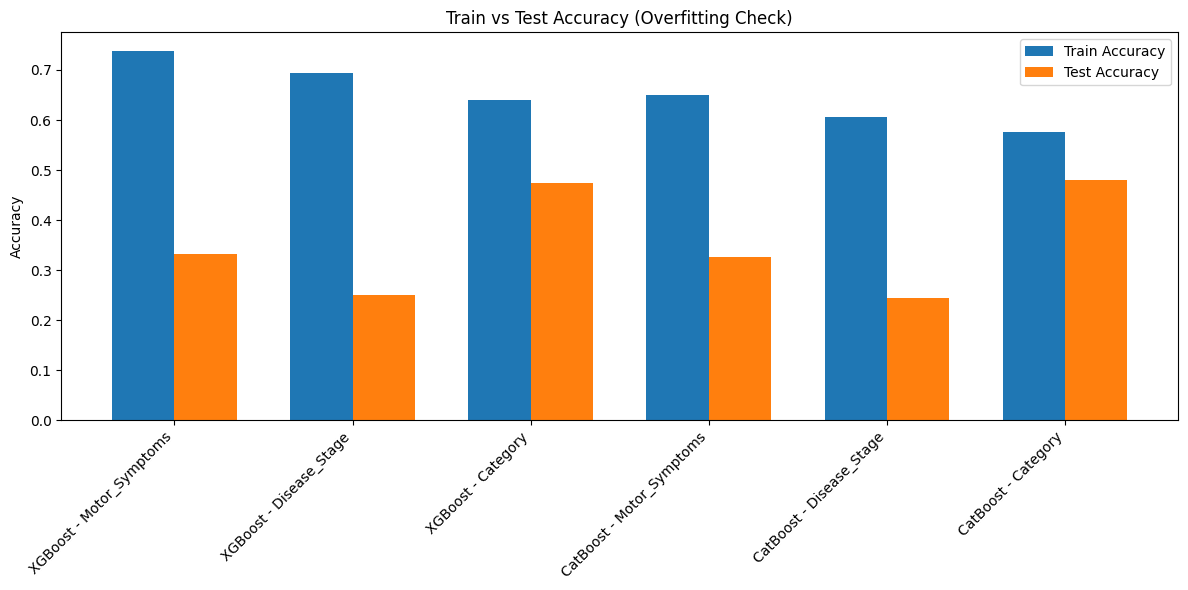

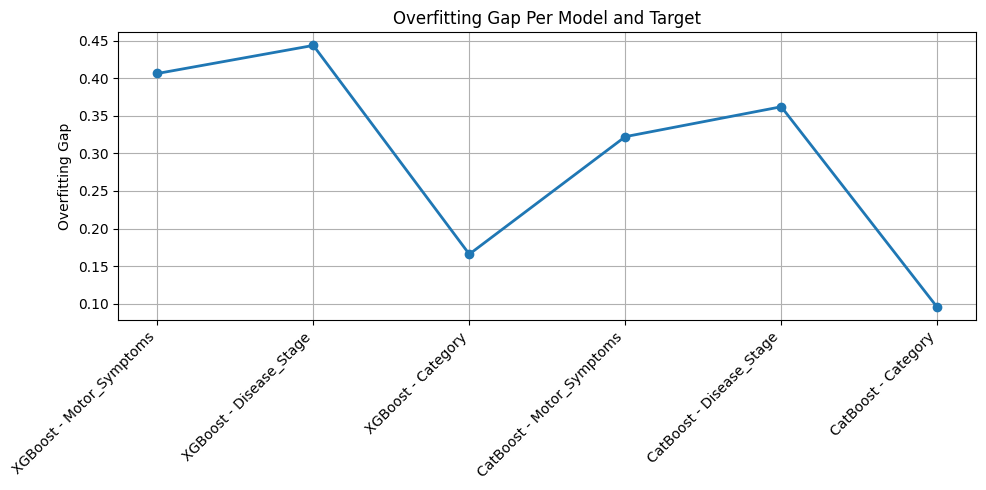

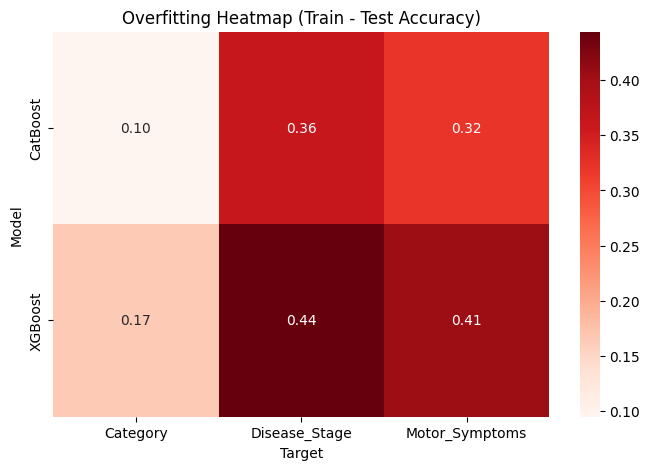

In [9]:
# OVERFITTING GRAPHS

# BAR PLOT – Train vs Test Accuracy
plt.figure(figsize=(12, 6))
x_labels = []
train_values = []
test_values = []

for i, row in results_df.iterrows():
    x_labels.append(f"{row['Model']} - {row['Target']}")
    train_values.append(row["Train Accuracy"])
    test_values.append(row["Test Accuracy"])

x = np.arange(len(x_labels))
width = 0.35

plt.bar(x - width/2, train_values, width, label="Train Accuracy")
plt.bar(x + width/2, test_values, width, label="Test Accuracy")

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Overfitting Check)")
plt.legend()
plt.tight_layout()
plt.show()


# LINE PLOT – Overfitting Gap (Train - Test)
overfit_gap = results_df["Train Accuracy"] - results_df["Test Accuracy"]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, overfit_gap, marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Overfitting Gap")
plt.title("Overfitting Gap Per Model and Target")
plt.grid(True)
plt.tight_layout()
plt.show()


# HEATMAP – Overfitting severity
gap_matrix = results_df.pivot(index="Model", columns="Target", values="Train Accuracy") - \
             results_df.pivot(index="Model", columns="Target", values="Test Accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(gap_matrix, annot=True, cmap="Reds", fmt=".2f")
plt.title("Overfitting Heatmap (Train - Test Accuracy)")
plt.show()
